# BESS-JPL Sensitivity Analysis with ECOv002 Cal-Val

This notebook performs a sensitivity analysis of the BESS-JPL model using ECOSTRESS Collection 2 Cal-Val data. It loads input data, processes it through the BESS-JPL model, and visualizes the impact of input perturbations on latent heat flux. The notebook also generates figures for publication and explores the relationship between surface temperature and latent heat flux.

## Import Required Libraries and Functions

This cell imports all necessary libraries and functions for data processing, model execution, statistical analysis, and plotting. It includes custom modules for the BESS-JPL model, sensitivity analysis, and net radiation calculations, as well as standard scientific Python libraries.

In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
from typing import Callable
from os import makedirs
from os.path import join
import numpy as np
import pandas as pd
from verma_net_radiation import verma_net_radiation_table
from ECOv003_L3T_L4T_JET import process_JET_table, load_ECOv002_calval_JET_inputs
from monte_carlo_sensitivity import perturbed_run, sensitivity_analysis, divide_absolute_by_unperturbed, sensitivity_magnitude_barchart
import matplotlib.pyplot as plt
from scipy.stats import mstats
import seaborn as sns
from matplotlib.ticker import FuncFormatter

## Define Processing Function for Model Table

This cell defines the forward process for analysis as the BESS-JPL model.

In [2]:
forward_process = process_JET_table
model_name = "JET"

## Set Normalization Function

This cell assigns the normalization function used to compare perturbed model outputs to the unperturbed baseline. The function `divide_absolute_by_unperturbed` is used for normalization in the sensitivity analysis.

In [3]:
normalization_function = divide_absolute_by_unperturbed

## Load and Filter Input Data

This cell loads the ECOSTRESS Cal-Val input data using a custom loader function and filters out surface temperatures greater than 50 Celsius and NDVI values less than 0.05. The resulting DataFrame is displayed for inspection.

In [4]:
input_df = load_ECOv002_calval_JET_inputs()
input_df = input_df[input_df.ST_C <= 50]
input_df = input_df[input_df.NDVI.apply(lambda NDVI: NDVI > 0.05)]
input_df

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,CL,Tmin_open,Tmin_closed,VPD_open,VPD_closed,Tmin_C,Topt_C,fAPARmax,field_capacity,wilting_point
0,0,US-NC3,ENF,Cfa,270.345200,78.53355,392.851840,307.021970,487.383423,118.916280,...,0.0070,12.02,-8.0,650.0,4500.0,32.65892,10.09,0.4659,0.24,0.11
1,1,US-Mi3,CVM,Dfb,232.141600,229.20093,640.118470,375.089300,106.825577,167.919460,...,0.0065,11.39,-8.0,650.0,3500.0,20.56636,1.39,0.4865,0.31,0.14
2,2,US-Mi3,CVM,Dfb,356.355740,335.23154,625.661700,284.686250,NaN,132.936340,...,0.0065,11.39,-8.0,650.0,3500.0,20.56636,1.39,0.4865,0.31,0.14
3,3,US-Mi3,CVM,Dfb,332.938400,326.68680,624.254330,251.414490,178.827545,141.132420,...,0.0065,11.39,-8.0,650.0,3500.0,20.56636,1.39,0.4865,0.31,0.14
4,4,US-Mi3,CVM,Dfb,286.854030,237.21654,511.082180,228.520170,154.791626,114.809410,...,0.0065,11.39,-8.0,650.0,3500.0,20.56636,1.39,0.4865,0.31,0.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,1060,US-xAE,GRA,Cfa,70.923310,172.37459,81.645230,15.282976,NaN,56.385185,...,NaN,NaN,NaN,NaN,NaN,NaN,7.99,0.3387,0.28,0.13
1061,1061,US-xAE,GRA,Cfa,116.543190,121.81641,65.469320,22.186659,NaN,40.509410,...,NaN,NaN,NaN,NaN,NaN,NaN,7.99,0.3387,0.28,0.13
1062,1062,US-xAE,GRA,Cfa,129.880100,0.00000,118.777240,55.343586,NaN,52.403820,...,NaN,NaN,NaN,NaN,NaN,NaN,7.99,0.3387,0.28,0.13
1063,1063,US-xAE,GRA,Cfa,2.707851,140.38632,126.490524,40.434025,NaN,57.769722,...,NaN,NaN,NaN,NaN,NaN,NaN,7.99,0.3387,0.28,0.13


## Process Input Data Through Model

This cell applies the processing function to the filtered input data, running it through the model, and displays the resulting DataFrame.

In [5]:
processed = forward_process(input_df)
processed

[2026-01-28 09:02:42 INFO] starting PT-JPL-SM table processing
[2026-01-28 09:02:42 INFO] started extracting geometry from PT-JPL-SM input table
[2026-01-28 09:02:43 INFO] completed extracting geometry from PT-JPL-SM input table
[2026-01-28 09:02:43 INFO] started extracting time from PT-JPL-SM input table
[2026-01-28 09:02:43 INFO] completed extracting time from PT-JPL-SM input table
[2026-01-28 09:02:43 INFO] running Forest Light Environmental Simulator at [Timestamp('2019-10-02 19:09:00'), Timestamp('2019-06-23 18:17:00'), Timestamp('2019-06-27 16:35:00'), Timestamp('2019-06-30 15:44:00'), Timestamp('2019-07-01 14:53:00'), Timestamp('2019-07-08 12:22:00'), Timestamp('2020-10-05 17:19:00'), Timestamp('2019-06-23 18:17:00'), Timestamp('2019-06-30 15:44:00'), Timestamp('2019-07-01 14:53:00'), Timestamp('2019-07-08 12:22:00'), Timestamp('2019-08-25 17:08:00'), Timestamp('2019-10-09 18:18:00'), Timestamp('2021-04-06 20:52:00'), Timestamp('2021-04-13 18:34:00'), Timestamp('2021-04-17 17:01

,Unnamed: 0,ID,vegetation,climate,STICinst,BESSinst,MOD16inst,PTJPLSMinst,ETinst,ETinstUncertainty,...,LE_PMJPL_Wm2,ET_daylight_PMJPL_kg,G_PMJPL_Wm2,LE_instantaneous_Wm2,ET_daylight_kg,ET_uncertainty,GPP_inst_g_m2_s,ET_canopy_inst_kg_m2_s,WUE,AuxiliaryNWP
0,0,US-NC3,ENF,Cfa,270.345200,78.53355,392.851840,307.021970,487.383423,118.916280,...,333.509632,3.926174,60.425858,351.448461,4.137355,0.772359,0.000212,0.000109,1.943556,
1,1,US-Mi3,CVM,Dfb,232.141600,229.20093,640.118470,375.089300,106.825577,167.919460,...,287.746228,3.776037,99.328964,326.039533,4.278552,1.239080,0.000269,0.000111,2.421845,
2,2,US-Mi3,CVM,Dfb,356.355740,335.23154,625.661700,284.686250,NaN,132.936340,...,268.156219,3.509339,94.519459,335.227024,4.355584,0.920854,0.000251,0.000044,5.670131,
3,3,US-Mi3,CVM,Dfb,332.938400,326.68680,624.254330,251.414490,178.827545,141.132420,...,296.928553,3.951882,78.277108,332.815927,4.433988,0.372604,0.000303,0.000049,6.158837,
4,4,US-Mi3,CVM,Dfb,286.854030,237.21654,511.082180,228.520170,154.791626,114.809410,...,285.218829,4.167672,70.628272,290.934683,4.251193,0.369447,0.000283,0.000058,4.846558,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060,1060,US-xAE,GRA,Cfa,70.923310,172.37459,81.645230,15.282976,NaN,56.385185,...,6.955198,0.077397,5.985288,35.172955,0.423775,0.428256,0.000006,0.000008,0.723558,
1061,1061,US-xAE,GRA,Cfa,116.543190,121.81641,65.469320,22.186659,NaN,40.509410,...,0.439605,0.009217,23.006297,37.569789,0.811693,1.321463,0.000015,0.000012,1.260016,
1062,1062,US-xAE,GRA,Cfa,129.880100,0.00000,118.777240,55.343586,NaN,52.403820,...,0.036051,0.000799,43.185134,27.267393,0.584567,0.709445,0.000041,0.000031,1.332510,
1063,1063,US-xAE,GRA,Cfa,2.707851,140.38632,126.490524,40.434025,NaN,57.769722,...,1.936771,0.034415,28.164673,58.151051,1.080137,0.608854,0.000024,0.000023,1.048858,


## Accuracy Comparison of In-Situ Observations to Model Estimates

Examining the accuracy of model estimates compared to ground data.

analyzing JET accuracy for ET_daylight_kg compared to insitu_ET_daylight_kg


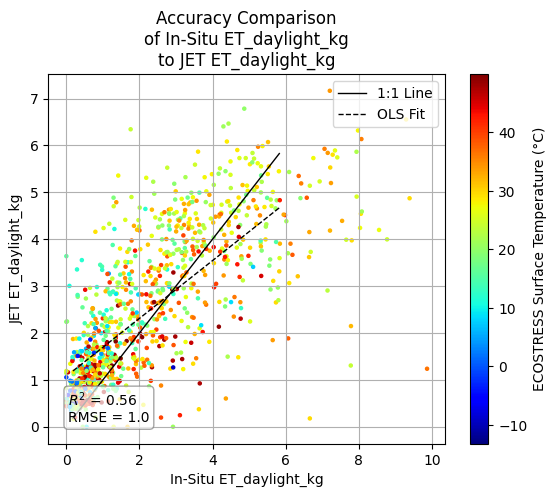

analyzing JET accuracy for G_Wm2 compared to insitu_G_Wm2
Error processing G_Wm2: "['G_Wm2'] not in index"
analyzing JET accuracy for H_Wm2 compared to insitu_H_Wm2
Error processing H_Wm2: "['H_Wm2'] not in index"
analyzing JET accuracy for LE_Wm2 compared to insitu_LE_Wm2
Error processing LE_Wm2: "['LE_Wm2'] not in index"
analyzing JET accuracy for LE_daylight_Wm2 compared to insitu_LE_daylight_Wm2
Error processing LE_daylight_Wm2: "['LE_daylight_Wm2'] not in index"
analyzing JET accuracy for Rn_Wm2 compared to insitu_Rn_Wm2


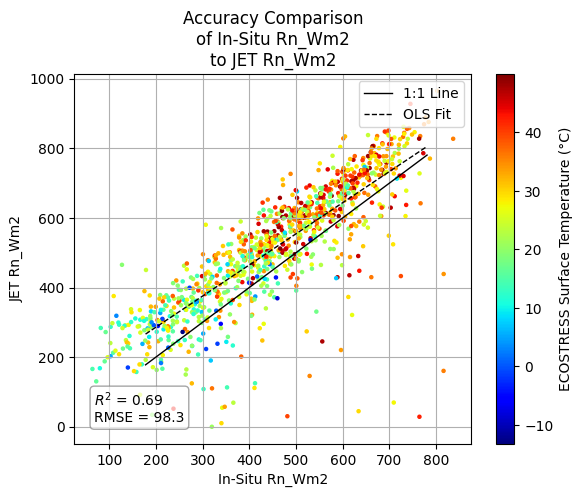

analyzing JET accuracy for Rn_daylight_Wm2 compared to insitu_Rn_daylight_Wm2
Error processing Rn_daylight_Wm2: "['Rn_daylight_Wm2'] not in index"
analyzing JET accuracy for SWin_Wm2 compared to insitu_SWin_Wm2


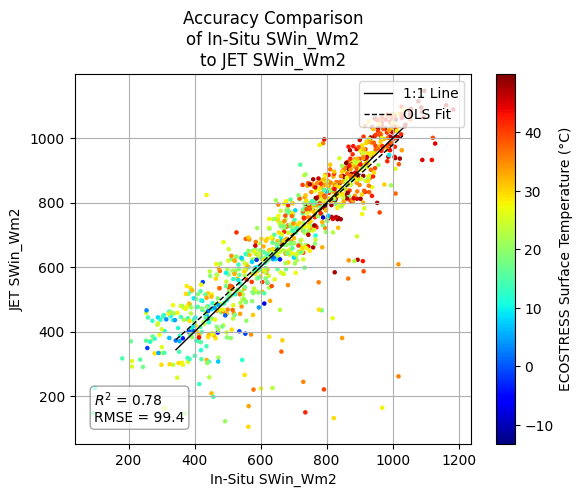

In [13]:
insitu_columns = sorted([column for column in processed.columns if "insitu" in column])

for insitu_variable in insitu_columns:
    try:
        variable = insitu_variable.replace("insitu_", "")
        print(f"analyzing {model_name} accuracy for {variable} compared to {insitu_variable}")
        
        x_variable = insitu_variable
        y_variable = variable

        # Filter out rows with NaN values in either variable
        valid_data = processed[[x_variable, y_variable, 'ST_C']].dropna()
        
        sc = plt.scatter(
            x=valid_data[x_variable],
            y=valid_data[y_variable],
            c=valid_data.ST_C,
            cmap="jet",
            color=None,
            s=5
        )

        # Calculate 5% and 95% tails for x and y variables
        x_5th, x_95th = np.percentile(valid_data[x_variable], [5, 95])
        y_5th, y_95th = np.percentile(valid_data[y_variable], [5, 95])

        min_val = min(x_5th, y_5th)
        max_val = max(x_95th, y_95th)

        # Add 1-to-1 line
        # min_val = min(valid_data[x_variable].min(), valid_data[y_variable].min())
        # max_val = max(valid_data[x_variable].max(), valid_data[y_variable].max())
        plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', linewidth=1, label='1:1 Line')

        # Add OLS regression line
        coefs = np.polyfit(valid_data[x_variable], valid_data[y_variable], 1)
        ols_x = np.array([min_val, max_val])
        ols_y = coefs[0] * ols_x + coefs[1]
        plt.plot(ols_x, ols_y, color='black', linestyle='--', linewidth=1, label='OLS Fit')

        # Calculate R-squared and RMSE
        from sklearn.metrics import r2_score, mean_squared_error
        y_true = valid_data[y_variable]
        y_pred = coefs[0] * valid_data[x_variable] + coefs[1]
        r2 = r2_score(y_true, y_pred)
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))

        # Annotate R-squared and RMSE on plot in lower left corner
        plt.annotate(f"$R^2$ = {r2:.2f}\nRMSE = {rmse:.1f}",
                    xy=(0.05, 0.05), xycoords='axes fraction',
                    ha='left', va='bottom',
                    fontsize=10,
                    bbox=dict(boxstyle='round', fc='white', ec='gray', alpha=0.7))

        # Set ticks every 100 for both axes
        # xticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
        # yticks = np.arange(100 * (min_val // 100), 100 * (max_val // 100 + 2), 100)
        # plt.xticks(xticks)
        # plt.yticks(yticks)

        plt.grid(True, zorder=0) 
        plt.xlabel(f"In-Situ {variable}")
        plt.ylabel(f"{model_name} {variable}")
        plt.title(f"Accuracy Comparison\nof In-Situ {variable}\nto {model_name} {variable}")
        plt.colorbar(sc, label="ECOSTRESS Surface Temperature (°C)")
        plt.legend(loc='upper right')
        plt.savefig(f"Accuracy Comparison of In-Situ {variable} to {model_name} {variable}.jpeg", format='jpeg', bbox_inches='tight')
        plt.savefig(f"Accuracy Comparison of In-Situ {variable} to {model_name} {variable}.svg", format='svg', bbox_inches='tight')
        plt.show()
    except Exception as e:
        print(f"Error processing {variable}: {e}")
        continue    
    

## Plot Unperturbed Comparison of Surface Temperature to Net Radiation

This cell creates a scatter plot comparing ECOSTRESS surface temperature to net radiation for the unperturbed data. The plot is saved as both JPEG and SVG files for publication or further analysis.

In [ ]:
plt.scatter(x=processed.ST_C, y=processed.Rn_Wm2, color='black', s=10, zorder=5)
plt.grid(True, zorder=0)
plt.xlabel("ECOSTRESS Surface Temperature (°C)")
plt.ylabel(f"{model_name} Net Radiation (W/m$^2$)")
plt.title(f"Unperturbed Comparison\nof ECOSTRESS Surface Temperature\nto {model_name} Net Radiation", pad=20)

plt.savefig(f"Unperturbed Comparison of ECOSTRESS Surface Temperature to {model_name} Net Radiation.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig(f"Unperturbed Comparison of ECOSTRESS Surface Temperature to {model_name} Net Radiation.svg", format='svg', bbox_inches='tight')
plt.show()

## Plot Unperturbed Comparison of Surface Temperature to Evapotranspiration

This cell creates a scatter plot comparing ECOSTRESS surface temperature to BESS-JPL evapotranspiration for the unperturbed data. The plot is saved as both JPEG and SVG files for publication or further analysis.

In [ ]:
plt.xticks(range(int(min(processed.ST_C)), int(max(processed.ST_C)) + 1, 5))
plt.scatter(x=processed.ST_C, y=processed.ET_daylight_kg, color='black', s=10, zorder=5)
plt.grid(True, zorder=0)
plt.xlabel("ECOSTRESS Surface Temperature (°C)")
plt.ylabel(f"{model_name} Evapotranspiration (mm/day)")
plt.title(f"Unperturbed Comparison\nof ECOSTRESS Surface Temperature\nto {model_name} Evapotranspiration")
plt.savefig(f"Unperturbed Comparison of ECOSTRESS Surface Temperature to {model_name} Evapotranspiration.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig(f"Unperturbed Comparison of ECOSTRESS Surface Temperature to {model_name} Evapotranspiration.svg", format='svg', bbox_inches='tight')

plt.show()

## Check Number of Valid Input Rows

This cell displays the number of rows remaining in the input DataFrame after all filtering steps, confirming the size of the dataset used for analysis.

In [ ]:
len(input_df)

## Perturbed Model Analysis for Net Radiation

In [ ]:
input_variable = "ST_C"
output_variable = "Rn_Wm2"

Rn_results = perturbed_run(
    input_df=input_df, 
    input_variable=input_variable, 
    output_variable=output_variable, 
    forward_process=process_BESS_table,
    normalization_function=normalization_function
)

Rn_results

## Perturbed Model Analysis for Evapotranspiration

In [ ]:
input_variable = "ST_C"
output_variable = "ET_daylight_kg"

ET_results = perturbed_run(
    input_df=input_df, 
    input_variable=input_variable, 
    output_variable=output_variable, 
    forward_process=forward_process,
    normalization_function=normalization_function
)

ET_results = ET_results.dropna()

ET_results

## Plot Change in Surface Temperature vs Net Radiation

This cell generates a scatter plot showing the relationship between changes in surface temperature and changes in BESS-JPL net radiation due to input perturbations. The plot is saved as JPEG and SVG files.

In [ ]:
sc = plt.scatter(
    x=Rn_results.input_perturbation, 
    y=Rn_results.output_perturbation, 
    c=Rn_results.input_unperturbed, 
    color=None,
    cmap="jet",
    s=3,
    alpha=0.5, 
    zorder=5
)

plt.grid(True, zorder=0)
plt.xlabel("Change in Surface Temperature (°C)")
plt.ylabel(f"Change in {model_name} Net Radiation (W/m$^2$)")
plt.title(f"Comparison of Change\nin Surface Temperature\nto {model_name} Net Radiation", pad=20)
plt.colorbar(sc, label="ECOSTRESS Surface Temperature (°C)")
plt.savefig(f"Comparison of Change in Surface Temperature to {model_name} Net Radiation.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig(f"Comparison of Change in Surface Temperature to {model_name} Net Radiation.svg", format='svg', bbox_inches='tight')
plt.show()

## Plot Change in Surface Temperature vs Evapotranspiration

This cell generates a scatter plot showing the relationship between changes in surface temperature and changes in evapotranspiration due to input perturbations. The plot is saved as JPEG and SVG files.

In [ ]:
sc = plt.scatter(
    x=ET_results.input_perturbation, 
    y=ET_results.output_perturbation, 
    c=ET_results.input_unperturbed, 
    color=None,
    cmap="jet",
    s=3,
    alpha=0.5, 
    zorder=5
)

plt.grid(True, zorder=0)
plt.xlabel("Change in Surface Temperature (°C)")
plt.ylabel(f"Change in {model_name} Evapotranspiration (mm/day)")
plt.title(f"Comparison of Change\nin Surface Temperature\nto {model_name} Evapotranspiration")
plt.colorbar(sc, label="ECOSTRESS Surface Temperature (°C)")
plt.savefig(f"Comparison of Change in Surface Temperature to {model_name} Evapotranspiration.jpeg", format='jpeg', bbox_inches='tight')
plt.savefig(f"Comparison of Change in Surface Temperature to {model_name} Evapotranspiration.svg", format='svg', bbox_inches='tight')
plt.show()

## Run Full Sensitivity Analysis for Multiple Inputs

This cell performs a comprehensive sensitivity analysis by perturbing several input variables (surface temperature, NDVI, albedo, air temperature, relative humidity) and measuring their effect on latent heat flux. The results are summarized in a DataFrame.

In [ ]:
input_variables = [
    "ST_C",
    "NDVI",
    "albedo",
    "Ta_C",
    "RH",
    "AOT",
    "COT",
    "vapor_gccm",
    "ozone_cm",
    "elevation_m",
    "canopy_height_meters"
]

output_variables = [
    "Rn_Wm2",
    "ET_daylight_kg",
    "GPP"
]

perturbation_df, sensitivity_metrics_df = sensitivity_analysis(
    input_df=input_df,
    input_variables=input_variables,
    output_variables=output_variables,
    forward_process=process_BESS_table,
    normalization_function=normalization_function
)

sensitivity_metrics_df

## Plot Sensitivity Magnitude Bar Chart

This cell creates a bar chart showing the average percent change in latent heat flux for each input variable, visualizing the magnitude of model sensitivity to each input.

In [ ]:
for output_variable in output_variables:
    sensitivity_magnitude_barchart(
        model_name=model_name,
        output_variable=output_variable,
        df=sensitivity_metrics_df
    )

## Summary and Next Steps

This notebook demonstrated a full sensitivity analysis workflow for the BESS-JPL model using ECOSTRESS Cal-Val data. Key results include the identification of input variables with the greatest influence on latent heat flux. Next steps could include further exploration of model parameters, additional visualizations, or application to other datasets.